# Análisis del uso por plataforma

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

Carga de dataframes

In [2]:
auctions = pd.read_csv('auctions.csv')
auctions.drop('auction_type_id', axis = 1, inplace = True)  #todas Nan
auctions["date"] =  pd.to_datetime(auctions["date"], errors = "coerce")

In [3]:
clicks_dtypes = {'advertiser': np.int8, 'action_id': np.float16, 'source_id': np.int8, 'country_code': 'category',
                 'latitude': np.float16, 'longitude': np.float16, 'carrier_id': np.float16, 'brand': np.float16,
                 'touchX': np.float16, 'touchY': np.float16}

clicks = pd.read_csv('clicks.csv', dtype = clicks_dtypes)
clicks["created"] =  pd.to_datetime(clicks["created"], errors = "coerce") #parseo de fechas
clicks.drop('action_id', axis = 1, inplace = True) #todos NaN
clicks.drop('wifi_connection', axis = 1, inplace = True) #todos False

In [4]:
events = pd.read_csv('events.csv', low_memory=False)

events["date"] =  pd.to_datetime(events["date"], errors = "coerce")

In [5]:
installs_dtypes = {'application_id': 'category', 'kind': 'category'}

installs = pd.read_csv('installs.csv', dtype = installs_dtypes)
installs["created"] =  pd.to_datetime(installs["created"], errors = "coerce") #parseo de fechas
installs.drop('attributed', axis = 1, inplace = True) #son todas false
installs.drop('click_hash', axis = 1, inplace = True) #son todas NaN

## ¿Cuál es la distribución de subastas por hora? ¿Pertenecen en mayor medida a Android o iOS?

In [6]:
auctions['cant_subastas'] = 1
auctions['hora'] = auctions['date'].dt.hour
group_auctions = auctions.groupby(['hora','platform']).agg({'cant_subastas':'count'})

In [7]:
subastas_por_hora = group_auctions.unstack().cant_subastas

Text(0, 0.5, 'Cantidad de subastas')

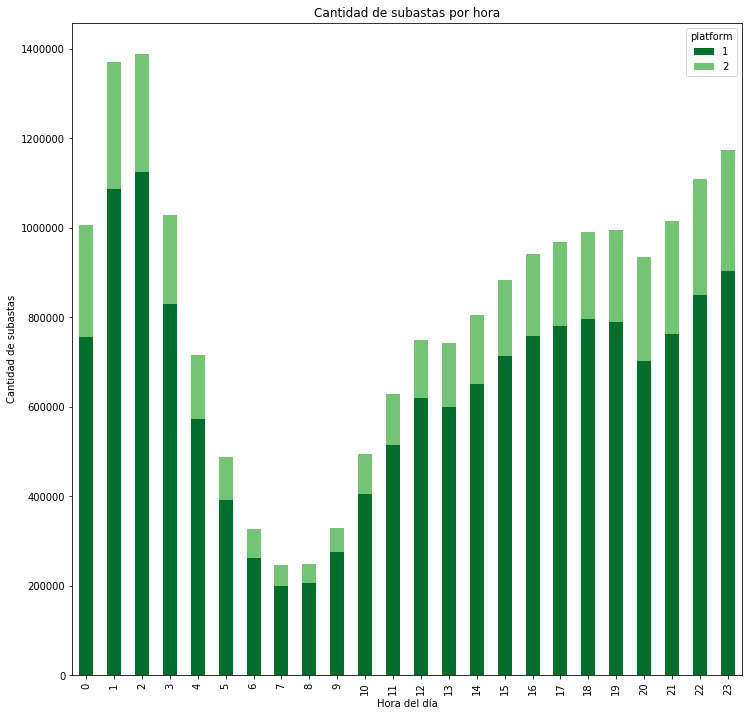

In [8]:
colors = ["#006D2C","#74C476"]
plot = subastas_por_hora.plot.bar(stacked=True, color=colors, figsize=(12,12), title = "Cantidad de subastas por hora")
plot.set_xlabel("Hora del día")
plot.set_ylabel("Cantidad de subastas")

## Distribución por plataforma

La librería puede instalarse con: 'sudo pip install plotly'

In [9]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
import plotly.graph_objs as go

In [10]:
installs_by_plataform = auctions[["device_id","platform"]]\
    .merge(installs[["ref_hash"]],left_on="device_id",right_on="ref_hash").drop_duplicates() 
clicks_by_plataform = auctions[["device_id","platform"]]\
    .merge(clicks[["ref_hash"]],left_on="device_id",right_on="ref_hash").drop_duplicates()
events_by_plataform = auctions[["device_id","platform"]]\
    .merge(events[["ref_hash"]],left_on="device_id",right_on="ref_hash").drop_duplicates() 

In [11]:
df_plataform = pd.DataFrame(installs_by_plataform.platform.value_counts())
df_plataform.rename(columns={"platform":"installed"},inplace=True)
df_plataform = df_plataform.join(pd.DataFrame(auctions["platform"].value_counts()))
df_plataform.rename(columns={"platform":"auctions"},inplace=True)
df_plataform = df_plataform.join(clicks_by_plataform.platform.value_counts())
df_plataform.rename(columns={"platform":"clicks"},inplace=True)
df_plataform = df_plataform.join(events_by_plataform.platform.value_counts())
df_plataform.rename(columns={"platform":"events"},inplace=True)

df_plataform["porcentaje_installed"] = df_plataform["installed"] * 100 / df_plataform["auctions"]
df_plataform["porcentaje_events"] = df_plataform["events"] * 100 / df_plataform["auctions"]
df_plataform["porcentaje_clicks"] = df_plataform["clicks"] * 100 / df_plataform["auctions"]

df_plataform["porcentaje_total_installed"] = df_plataform["installed"] *100 / df_plataform["installed"].sum()
df_plataform["porcentaje_total_events"] = df_plataform["events"] *100 / df_plataform["events"].sum()
df_plataform["porcentaje_total_clicks"] = df_plataform["clicks"] *100 / df_plataform["clicks"].sum()
df_plataform["porcentaje_total_auctions"] = df_plataform["auctions"] *100 / df_plataform["auctions"].sum()
df_plataform

,installed,auctions,clicks,events,porcentaje_installed,porcentaje_events,porcentaje_clicks,porcentaje_total_installed,porcentaje_total_events,porcentaje_total_clicks,porcentaje_total_auctions
2,500,4029494,493,21927,0.012409,0.544163,0.012235,50.301811,25.846948,2.903587,20.588771
1,494,15541825,16486,62907,0.003179,0.404759,0.106075,49.698189,74.153052,97.096413,79.411229


In [91]:
df_plataform_to_radial = df_plataform[["porcentaje_total_auctions","porcentaje_total_installed","porcentaje_total_events","porcentaje_total_clicks"]]
df_plataform_to_radial = df_plataform_to_radial.T
list_of_ticks = ["auctions",'installs','events','clicks']
data = [go.Scatterpolar(
  r = df_plataform_to_radial[1].tolist(),
  theta = list_of_ticks,
    name = 'Platform 1',
  fill = 'toself'
),go.Scatterpolar(
  r = df_plataform_to_radial[2].tolist(),
  theta = list_of_ticks,
    name = 'Platform 2',
  fill = 'toself'
)]

layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, 100],
        tickangle=-45
    ),
      angularaxis = dict(
        rotation = 45
      ),
  ),
    title='Porcentaje de participación por platform',
    font= dict(
        size =18
    ),
  showlegend = True
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

### Relacion installs / auctions

In [80]:
y = ['Platform 2 ', 'Platform 1 ']
x = df_plataform["porcentaje_installed"]

text = []
for i in x:
    text.append(str(round(i,5)) + "%")

data = [go.Bar(
            x=x,
            y=y,
            text=text,
            textposition = 'auto',
            orientation = 'h'
        )]
layout = go.Layout(
    title='Relacion installs / auctions por plataform',
    xaxis=dict(
        title='Porcentaje en función de auctions',
        range= [0,0.02],
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

### Relacion installs / auctions

In [83]:
y = ['Platform 2 ', 'Platform 1 ']
x = df_plataform["porcentaje_clicks"]

text = []
for i in x:
    text.append(str(round(i,3)) + "%")

data = [go.Bar(
            x=x,
            y=y,
            text=text,
            textposition = 'auto',
            orientation = 'h'
        )]
layout = go.Layout(
    title='Relacion clicks / auctions por plataform',
    xaxis=dict(
        title='Porcentaje en función de auctions',
        #range= [0,0.02],
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

### Relacion events / auctions

In [85]:
y = ['Platform 2 ', 'Platform 1 ']
x = df_plataform["porcentaje_events"]

text = []
for i in x:
    text.append(str(round(i,3)) + "%")

data = [go.Bar(
            x=x,
            y=y,
            text=text,
            textposition = 'auto',
            orientation = 'h'
        )]
layout = go.Layout(
    title='Relacion events / auctions por plataform',
    xaxis=dict(
        title='Porcentaje en función de auctions',
        range= [0,1],
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)